<a href="https://colab.research.google.com/github/flohmannjr/tensorflow_curso/blob/main/Cota%C3%A7%C3%A3o_do_Milho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cotação do Milho, NY Futuros, 01.02.2013 a 31.01.2023

Fonte: Investing.com - https://br.investing.com/commodities/us-corn

Tipo: Commodities - Grupo: Agrícola - Unidade: 1 Celemim

# Importações

In [ ]:
import tensorflow as tf

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import absl.logging, os

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, Conv1D, Dense, GRU, Lambda, LSTM
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# Configurações

In [ ]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100

plt.style.use('seaborn-darkgrid')

absl.logging.set_verbosity(absl.logging.ERROR)  # Apresentar apenas erros.

## Constantes

In [ ]:
SEMENTE = 2008193

COR_TREINO   = '#663399'
COR_PREVISAO = '#f22424'
COR_TESTE    = '#345cd3'

LINHA_ESPESSURA = 1

TAMANHO_CNN = 128

ATIVACAO_CNN = 'relu'
ATIVACAO_HORIZONTE = 'linear'
ATIVACAO_RNN = 'tanh'

PERDA = 'mae'
METRICAS = ['mae', 'mse']

ITERACOES = 100
TAMANHO_LOTE = 128
CAMINHO_MARCOS = 'marcos'

FILTROS = 128
TAMANHO_NUCLEO = 5
PREENCHIMENTO = 'causal'

UNIDADES = 128

## Funções

In [ ]:
!wget https://raw.githubusercontent.com/flohmannjr/tensorflow_curso/main/funcoes_temporais.py

--2023-02-10 18:20:22--  https://raw.githubusercontent.com/flohmannjr/tensorflow_curso/main/funcoes_temporais.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3787 (3.7K) [text/plain]
Saving to: ‘funcoes_temporais.py’

funcoes_temporais.p 100%[===================>]   3.70K  --.-KB/s    in 0s      

2023-02-10 18:20:23 (46.0 MB/s) - ‘funcoes_temporais.py’ saved [3787/3787]



In [ ]:
from funcoes_temporais import grafico_series, grafico_metrica, mean_absolute_scaled_error, metricas_modelo, criar_janelas, separar_janelas_treino_teste, criar_marco_modelo

# Dados

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/flohmannjr/tensorflow_curso/main/dados/milho_ny_20130201_20230131.csv',
                 parse_dates=['Data'],
                 dayfirst=True,  # 'Data' está no formato dd.mm.aaaa.
                 index_col=['Data'])

df = df.sort_index()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2549 entries, 2013-02-01 to 2023-01-31
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Último    2549 non-null   float64
 1   Abertura  2549 non-null   float64
 2   Máxima    2549 non-null   float64
 3   Mínima    2549 non-null   float64
 4   Vol.      2516 non-null   object 
 5   Var%      2549 non-null   object 
dtypes: float64(4), object(2)
memory usage: 139.4+ KB


In [ ]:
df_wasde = pd.read_csv('https://raw.githubusercontent.com/flohmannjr/tensorflow_curso/main/dados/wasde_corn_avg_farm_price_est_us_201301_202301.csv',
                       parse_dates=['ReportDate'])

In [ ]:
df_wasde.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   WasdeNumber    95 non-null     int64         
 1   Region         95 non-null     object        
 2   Commodity      95 non-null     object        
 3   Attribute      95 non-null     object        
 4   ProjEstFlag    95 non-null     object        
 5   ReportDate     95 non-null     datetime64[ns]
 6   MarketYear     95 non-null     object        
 7   Value          95 non-null     float64       
 8   Unit           95 non-null     object        
 9   ReleaseDate    95 non-null     object        
 10  ForecastYear   95 non-null     int64         
 11  ForecastMonth  95 non-null     int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(7)
memory usage: 9.0+ KB


## Limpeza e ajustes

In [ ]:
# Renomear colunas
df = df.rename(columns={'Último': 'Fechamento', 'Vol.': 'Volume', 'Var%': 'Variação'})

# 'Preço Médio Fazenda' com valores nulos
df['Preço Médio Fazenda'] = None

# Popular 'Preço Médio Fazenda' com valores WASDE
for i in df.index:
    valor = df_wasde['Value'][df_wasde['ReportDate'].dt.strftime('%Y%m') == i.strftime('%Y%m')]

    if len(valor) > 0:
        df.loc[i, 'Preço Médio Fazenda'] = int(valor)

# Popular 'Preço Médio Fazenda' não encontrados com valor anterior
df['Preço Médio Fazenda'] = df['Preço Médio Fazenda'].fillna(method='ffill')

# Retira a letra 'K' do final dos valores e modifica para 'float'.
df['Volume'] = df['Volume'].str[:-1].astype(float)

# Substitui valores indisponíveis por 0.
df['Volume'] = df['Volume'].fillna(0)

# Multiplica por 1000 e modifica para 'int'.
df['Volume'] = (df['Volume'] * 1000).astype(int)

# Retira o símbolo '%' do final dos valores, modifica para 'float' e divide por 100.
df['Variação'] = df['Variação'].str[:-1].astype(float) / 100

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2549 entries, 2013-02-01 to 2023-01-31
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Fechamento           2549 non-null   float64
 1   Abertura             2549 non-null   float64
 2   Máxima               2549 non-null   float64
 3   Mínima               2549 non-null   float64
 4   Volume               2549 non-null   int64  
 5   Variação             2549 non-null   float64
 6   Preço Médio Fazenda  2549 non-null   int64  
dtypes: float64(5), int64(2)
memory usage: 223.9 KB


In [ ]:
df.describe()

,Fechamento,Abertura,Máxima,Mínima,Volume,Variação,Preço Médio Fazenda
count,2549.000000,2549.000000,2549.000000,2549.000000,2549.000000,2549.000000,2549.000000
mean,446.056473,445.918807,450.706218,441.367187,122774.510396,0.000097,3.853668
std,123.883183,123.703861,125.930037,121.678627,84776.288079,0.016127,1.160648
min,301.500000,302.000000,307.250000,300.250000,0.000000,-0.173900,3.000000
25%,361.750000,361.500000,364.750000,358.500000,60380.000000,-0.008200,3.000000
50%,384.500000,384.500000,388.500000,380.500000,123570.000000,0.000200,3.000000
75%,512.250000,512.250000,518.250000,505.750000,174400.000000,0.008800,4.000000
max,818.250000,817.500000,827.000000,814.000000,523850.000000,0.080200,6.000000


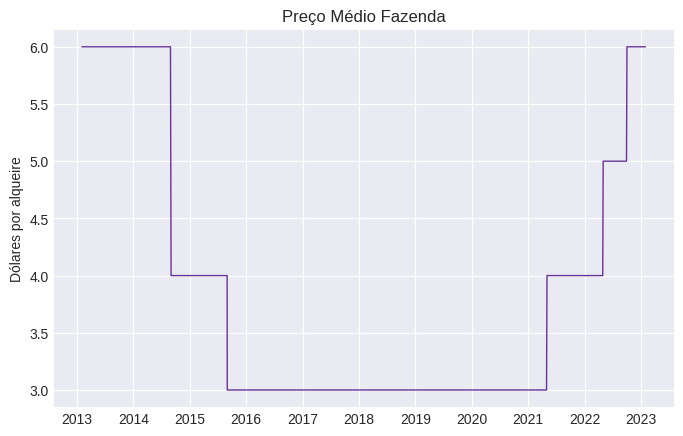

In [ ]:
sns.lineplot(data=df, x='Data', y='Preço Médio Fazenda', color=COR_TREINO, linewidth=LINHA_ESPESSURA)

plt.title('Preço Médio Fazenda')
plt.xlabel('')
plt.ylabel('Dólares por alqueire');

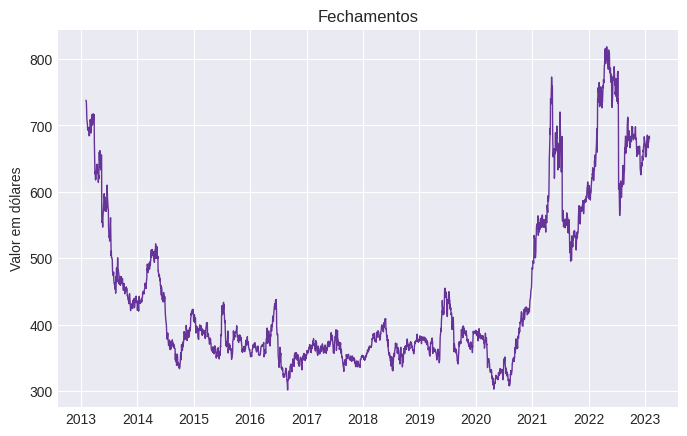

In [ ]:
sns.lineplot(data=df, x='Data', y='Fechamento', color=COR_TREINO, linewidth=LINHA_ESPESSURA)

plt.title('Fechamentos')
plt.xlabel('')
plt.ylabel('Valor em dólares');

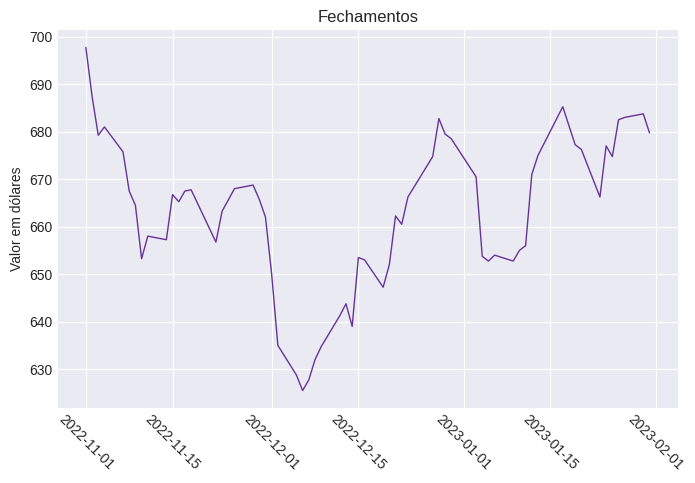

In [ ]:
df_recente = df[df.index >= '2022-11-01']

sns.lineplot(data=df_recente, x='Data', y='Fechamento', color=COR_TREINO, linewidth=LINHA_ESPESSURA)

plt.title('Fechamentos')
plt.xlabel('')
plt.ylabel('Valor em dólares')

plt.xticks(rotation=-45);

## Separação treino e teste

In [ ]:
treino_tamanho = int(len(df) * 0.8)  # 80% da base
treino_tamanho

2039

In [ ]:
X_train = df[:treino_tamanho].index.to_numpy()
y_train = df[:treino_tamanho]['Fechamento'].to_numpy()

X_test = df[treino_tamanho:].index.to_numpy()
y_test = df[treino_tamanho:]['Fechamento'].to_numpy()

len(X_train), len(y_train), len(X_test), len(y_test)

(2039, 2039, 510, 510)

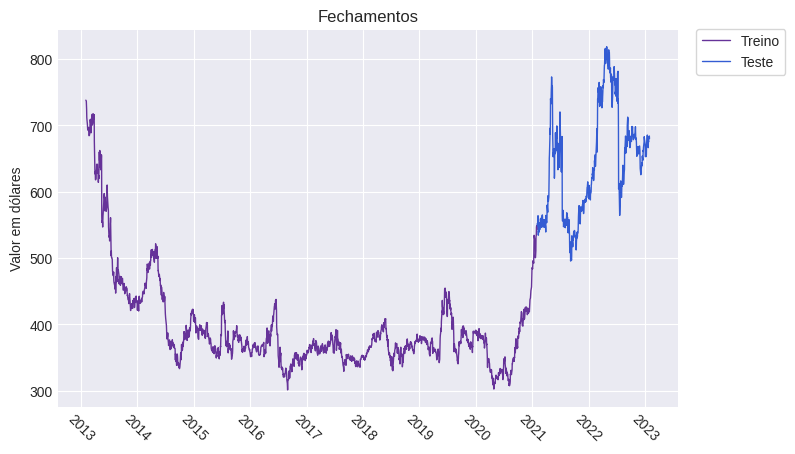

In [ ]:
grafico_series(X_treino=X_train, y_treino=y_train,
               X_teste=X_test, y_teste=y_test)

# Modelos

In [ ]:
metricas = [None] * 20

## Modelo 0: Naïve (Ingênuo, modelo-base.)

Naïve method: https://otexts.com/fpp3/simple-methods.html#na%C3%AFve-method

Para previsões ingênuas, simplesmente definimos todas as previsões como o valor da observação anterior.

In [ ]:
y_pred = y_test[:-1]

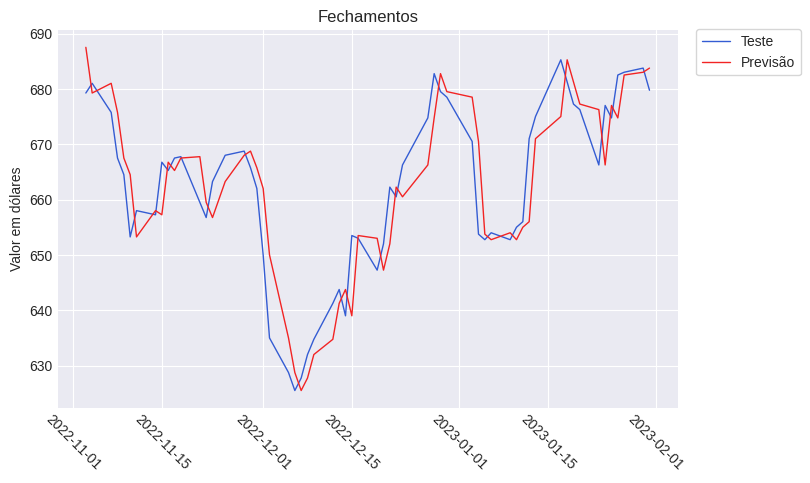

In [ ]:
grafico_series(X_teste=X_test, y_teste=y_test,
               X_previsao=X_test[1:], y_previsao=y_pred,  # As previsões são as mesmas das observações anteriores, portanto o primeiro valor dos dados de teste é ignorado.
               inicio=-60)                                # Mostrando somentes os últimos 60 registros, para facilitar a visualização.

O gráfico de previsões (ingênuo) não é um perfeito deslocamento do gráfico de testes, neste caso, pois os dados não possuem valor nos finais de semana e feriados, então os registros não têm um intervalo constante.

In [ ]:
metricas[0] = metricas_modelo(y_test[1:], y_pred)

## Separação dos dados em janelas e horizontes

Janela: Dados utilizados para fazer a previsão. (7 valores, neste projeto.)

Horizonte: Previsão. (1 valor, neste projeto.)

```
Janela                  Horizonte
[0, 1, 2, 3, 4, 5, 6]   [7]
[1, 2, 3, 4, 5, 6, 7]   [8]
[2, 3, 4, 5, 6, 7, 8]   [9]
```

In [ ]:
dados = df['Fechamento'].to_numpy().astype('float32')
precos = df['Preço Médio Fazenda'].to_numpy().astype('float32')
janela_tamanho = 7
horizonte_tamanho = 1

# janelas, horizontes = criar_janelas(dados, janela_tamanho, horizonte_tamanho)          # janela somente com Fechamentos.
janelas, horizontes = criar_janelas(dados, janela_tamanho, horizonte_tamanho, precos)  # janela com Fechamentos e Preço Médio Fazenda.

janelas_treino, janelas_teste, horizontes_treino, horizontes_teste = separar_janelas_treino_teste(janelas, horizontes, tamanho_teste=0.2)

## Modelo 1: scikit-learn Linear Regression

In [ ]:
modelo = LinearRegression()

modelo.fit(janelas_treino, horizontes_treino[:, 0])

y_pred = modelo.predict(janelas_teste)

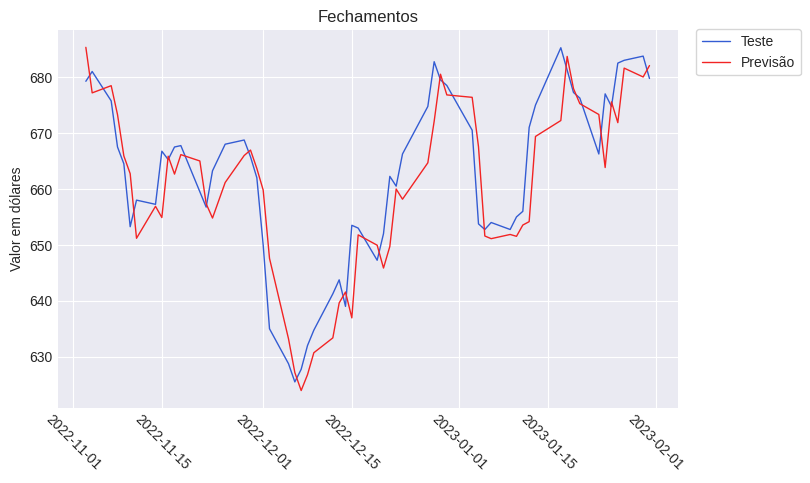

In [ ]:
grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=horizontes_teste[:, 0],
               X_previsao=X_test[-len(janelas_teste):], y_previsao=y_pred,
               inicio=-60)

In [ ]:
metricas[1] = metricas_modelo(horizontes_teste[:, 0], y_pred)

## Modelo 2: scikit-learn Support Vector Regression

In [ ]:
modelo = SVR()

modelo.fit(janelas_treino, horizontes_treino[:, 0])

y_pred = modelo.predict(janelas_teste)

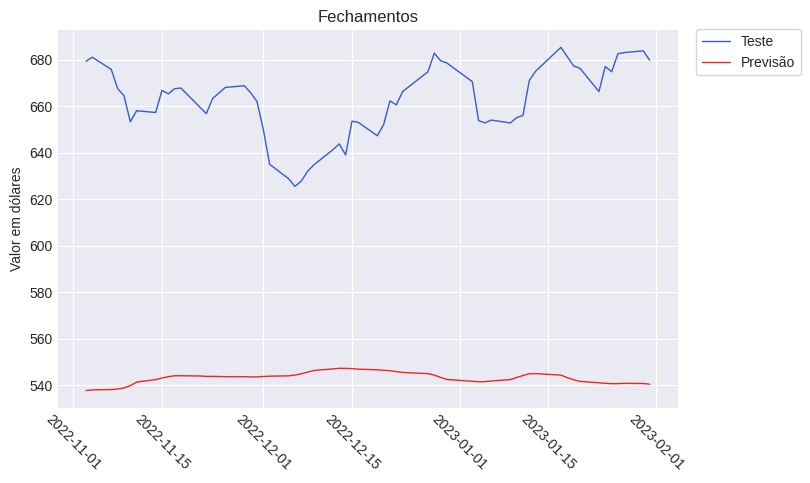

In [ ]:
grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=horizontes_teste[:, 0],
               X_previsao=X_test[-len(janelas_teste):], y_previsao=y_pred,
               inicio=-60)

In [ ]:
metricas[2] = metricas_modelo(horizontes_teste[:, 0], y_pred)

## Modelo 3: scikit-learn Random Forest Regression

In [ ]:
modelo = RandomForestRegressor()

modelo.fit(janelas_treino, horizontes_treino[:, 0])

y_pred = modelo.predict(janelas_teste)

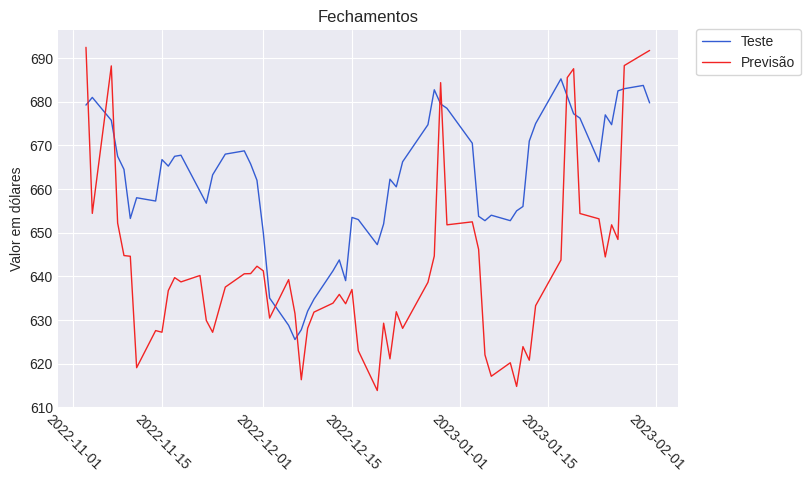

In [ ]:
grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=horizontes_teste[:, 0],
               X_previsao=X_test[-len(janelas_teste):], y_previsao=y_pred,
               inicio=-60)

In [ ]:
metricas[3] = metricas_modelo(horizontes_teste[:, 0], y_pred)

## Modelo 4: scikit-learn Multi-layer Perceptron Regression

In [ ]:
modelo = MLPRegressor()

modelo.fit(janelas_treino, horizontes_treino[:, 0])

y_pred = modelo.predict(janelas_teste)

/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


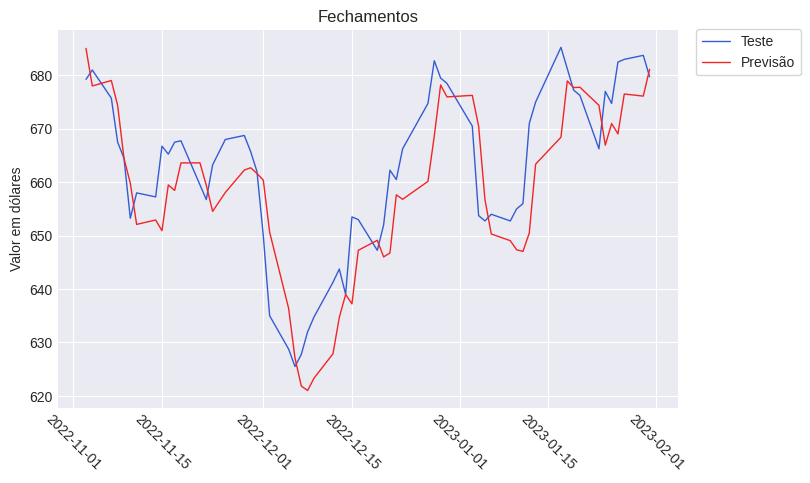

In [ ]:
grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=horizontes_teste[:, 0],
               X_previsao=X_test[-len(janelas_teste):], y_previsao=y_pred,
               inicio=-60)

In [ ]:
metricas[4] = metricas_modelo(horizontes_teste[:, 0], y_pred)

## Modelo 5: TensorFlow Dense

In [ ]:
tf.random.set_seed(SEMENTE)

modelo_nome = 'modelo_5_denso_7j_1h'

modelo = Sequential(name=modelo_nome)

modelo.add(Dense(units=TAMANHO_CNN, activation=ATIVACAO_CNN, name='camada_relu'))
modelo.add(Dense(units=horizonte_tamanho, activation=ATIVACAO_HORIZONTE, name='camada_saida'))

modelo.compile(loss=PERDA,
               optimizer=Adam(),
               metrics=METRICAS)

historico = modelo.fit(x=janelas_treino,
                       y=horizontes_treino,
                       epochs=ITERACOES,
                       batch_size=TAMANHO_LOTE,
                       validation_data=(janelas_teste, horizontes_teste),
                       callbacks=[criar_marco_modelo(modelo_nome, caminho=CAMINHO_MARCOS)],
                       verbose=0)

In [ ]:
modelo.summary()

Model: "modelo_5_denso_7j_1h"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 camada_relu (Dense)         (None, 128)               1152      
                                                                 
 camada_saida (Dense)        (None, 1)                 129       
                                                                 
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


In [ ]:
modelo.evaluate(janelas_teste, horizontes_teste)

16/16 [==============================] - 0s 2ms/step - loss: 10.0752 - mae: 10.0752 - mse: 229.3645


[10.075162887573242, 10.075162887573242, 229.364501953125]

In [ ]:
modelo = load_model(os.path.join(CAMINHO_MARCOS, modelo_nome))
modelo.evaluate(janelas_teste, horizontes_teste)

16/16 [==============================] - 0s 3ms/step - loss: 10.0752 - mae: 10.0752 - mse: 229.3645


[10.075162887573242, 10.075162887573242, 229.364501953125]

In [ ]:
previsoes = modelo.predict(janelas_teste)

16/16 [==============================] - 0s 2ms/step


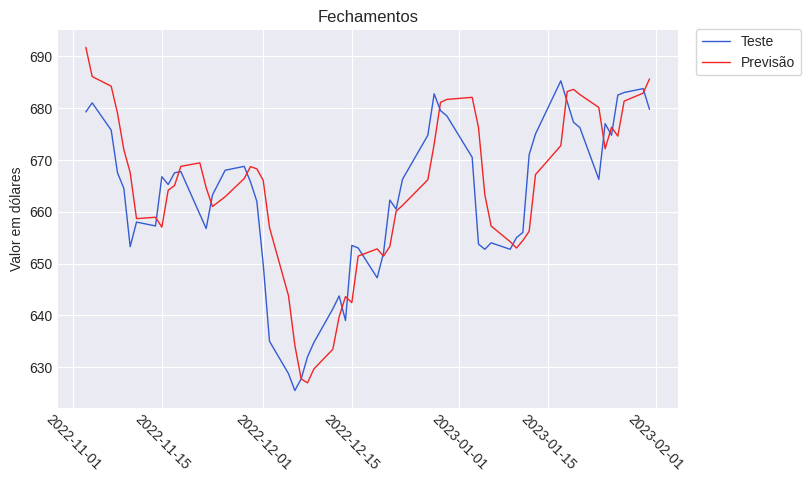

In [ ]:
grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=tf.squeeze(horizontes_teste),
               X_previsao=X_test[-len(janelas_teste):], y_previsao=tf.squeeze(previsoes),
               inicio=-60)

In [ ]:
metricas[5] = metricas_modelo(tf.squeeze(horizontes_teste), tf.squeeze(previsoes))

## Modelo 6: TensorFlow Convulational

In [ ]:
tf.random.set_seed(SEMENTE)

modelo_nome = 'modelo_6_convulacional'

modelo = Sequential(name=modelo_nome)

modelo.add(Lambda(lambda x: tf.expand_dims(x, axis=1), name='camada_lambda'))  # Adiciona uma dimensão (input_dim) aos dados. Conv1D espera (batch_size, timesteps, input_dim).

modelo.add(Conv1D(filters=FILTROS,
                  kernel_size=TAMANHO_NUCLEO,
                  padding=PREENCHIMENTO,
                  activation=ATIVACAO_CNN,
                  name='camada_convulacional'))

modelo.add(Dense(units=horizonte_tamanho, activation=ATIVACAO_HORIZONTE, name='camada_saida'))

modelo.compile(loss=PERDA,
               optimizer=Adam(),
               metrics=METRICAS)

modelo.fit(x=janelas_treino,
           y=horizontes_treino,
           epochs=ITERACOES,
           batch_size=TAMANHO_LOTE,
           validation_data=(janelas_teste, horizontes_teste),
           callbacks=[criar_marco_modelo(modelo_nome, caminho=CAMINHO_MARCOS)],
           verbose=0)

In [ ]:
modelo.summary()

Model: "modelo_6_convulacional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 camada_lambda (Lambda)      (None, 1, 8)              0         
                                                                 
 camada_convulacional (Conv1  (None, 1, 128)           5248      
 D)                                                              
                                                                 
 camada_saida (Dense)        (None, 1, 1)              129       
                                                                 
Total params: 5,377
Trainable params: 5,377
Non-trainable params: 0
_________________________________________________________________


In [ ]:
modelo.evaluate(janelas_teste, horizontes_teste)

16/16 [==============================] - 0s 4ms/step - loss: 11.4343 - mae: 11.4343 - mse: 284.7606


[11.434281349182129, 11.434281349182129, 284.7606201171875]

In [ ]:
modelo = load_model(os.path.join(CAMINHO_MARCOS, modelo_nome))
modelo.evaluate(janelas_teste, horizontes_teste)

16/16 [==============================] - 0s 4ms/step - loss: 11.3406 - mae: 11.3406 - mse: 293.5065


[11.340599060058594, 11.340599060058594, 293.5064697265625]

In [ ]:
previsoes = modelo.predict(janelas_teste)

16/16 [==============================] - 0s 2ms/step


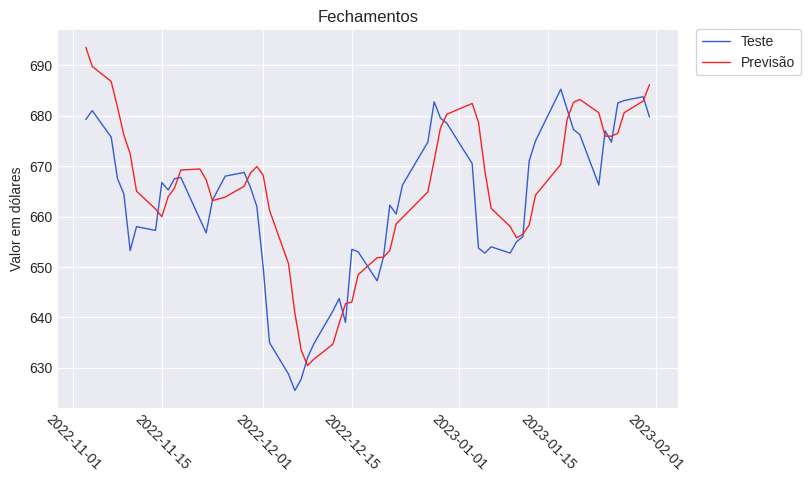

In [ ]:
grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=tf.squeeze(horizontes_teste),
               X_previsao=X_test[-len(janelas_teste):], y_previsao=tf.squeeze(previsoes),
               inicio=-60)

In [ ]:
metricas[6] = metricas_modelo(tf.squeeze(horizontes_teste), tf.squeeze(previsoes))

## Modelo 7: TensorFlow LSTM

In [ ]:
tf.random.set_seed(SEMENTE)

modelo_nome = 'modelo_7_lstm'

modelo = Sequential(name=modelo_nome)

modelo.add(Lambda(lambda x: tf.expand_dims(x, axis=1), name='camada_lambda'))
modelo.add(LSTM(units=UNIDADES, activation=ATIVACAO_CNN, name='camada_lstm'))  # Ativação 'relu' no lugar de 'tanh' por motivo de performance.
modelo.add(Dense(units=horizonte_tamanho, activation=ATIVACAO_HORIZONTE, name='camada_saida'))

modelo.compile(loss=PERDA,
               optimizer=Adam(),
               metrics=METRICAS)

modelo.fit(x=janelas_treino,
           y=horizontes_treino,
           epochs=ITERACOES,
           batch_size=TAMANHO_LOTE,
           validation_data=(janelas_teste, horizontes_teste),
           callbacks=[criar_marco_modelo(modelo_nome, caminho=CAMINHO_MARCOS)],
           verbose=0)

In [ ]:
modelo.summary()

Model: "modelo_7_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 camada_lambda (Lambda)      (None, 1, 8)              0         
                                                                 
 camada_lstm (LSTM)          (None, 128)               70144     
                                                                 
 camada_saida (Dense)        (None, 1)                 129       
                                                                 
Total params: 70,273
Trainable params: 70,273
Non-trainable params: 0
_________________________________________________________________


In [ ]:
modelo.evaluate(janelas_teste, horizontes_teste)

16/16 [==============================] - 0s 3ms/step - loss: 12.1886 - mae: 12.1886 - mse: 336.2674


[12.188626289367676, 12.188626289367676, 336.2673645019531]

In [ ]:
modelo = load_model(os.path.join(CAMINHO_MARCOS, modelo_nome))
modelo.evaluate(janelas_teste, horizontes_teste)

16/16 [==============================] - 0s 3ms/step - loss: 12.1886 - mae: 12.1886 - mse: 336.2674


[12.188626289367676, 12.188626289367676, 336.2673645019531]

In [ ]:
previsoes = modelo.predict(janelas_teste)

16/16 [==============================] - 0s 2ms/step


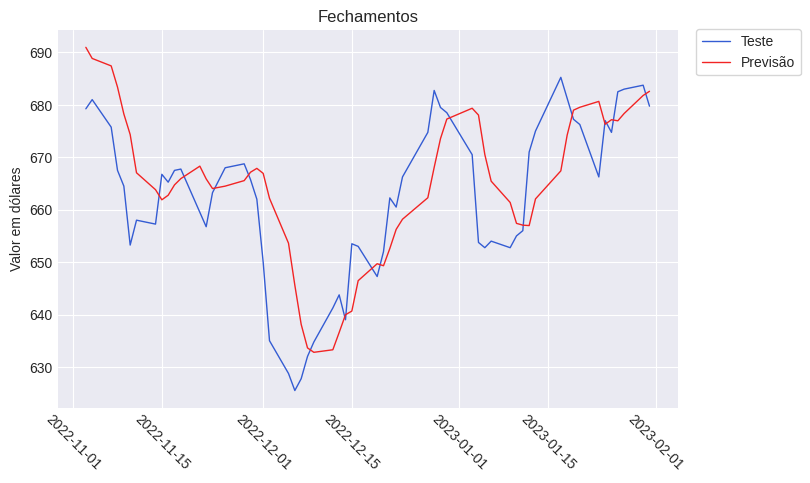

In [ ]:
grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=tf.squeeze(horizontes_teste),
               X_previsao=X_test[-len(janelas_teste):], y_previsao=tf.squeeze(previsoes),
               inicio=-60)

In [ ]:
metricas[7] = metricas_modelo(tf.squeeze(horizontes_teste), tf.squeeze(previsoes))

## Modelo 8: TensorFlow GRU

In [ ]:
tf.random.set_seed(SEMENTE)

modelo_nome = 'modelo_8_gru'

modelo = Sequential(name=modelo_nome)

modelo.add(Lambda(lambda x: tf.expand_dims(x, axis=1), name='camada_lambda'))
modelo.add(GRU(units=UNIDADES, activation=ATIVACAO_CNN, name='camada_gru'))
modelo.add(Dense(units=horizonte_tamanho, activation=ATIVACAO_HORIZONTE, name='camada_saida'))

modelo.compile(loss=PERDA,
               optimizer=Adam(),
               metrics=METRICAS)

modelo.fit(x=janelas_treino,
           y=horizontes_treino,
           epochs=ITERACOES,
           batch_size=TAMANHO_LOTE,
           validation_data=(janelas_teste, horizontes_teste),
           callbacks=[criar_marco_modelo(modelo_nome, caminho=CAMINHO_MARCOS)],
           verbose=0)

In [ ]:
modelo.summary()

Model: "modelo_8_gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 camada_lambda (Lambda)      (None, 1, 8)              0         
                                                                 
 camada_gru (GRU)            (None, 128)               52992     
                                                                 
 camada_saida (Dense)        (None, 1)                 129       
                                                                 
Total params: 53,121
Trainable params: 53,121
Non-trainable params: 0
_________________________________________________________________


In [ ]:
modelo.evaluate(janelas_teste, horizontes_teste)

16/16 [==============================] - 0s 3ms/step - loss: 12.6695 - mae: 12.6695 - mse: 349.7704


[12.669492721557617, 12.669492721557617, 349.7704162597656]

In [ ]:
modelo = load_model(os.path.join(CAMINHO_MARCOS, modelo_nome))
modelo.evaluate(janelas_teste, horizontes_teste)

16/16 [==============================] - 0s 3ms/step - loss: 12.5447 - mae: 12.5447 - mse: 357.7982


[12.54472541809082, 12.54472541809082, 357.7981872558594]

In [ ]:
previsoes = modelo.predict(janelas_teste)

16/16 [==============================] - 0s 2ms/step


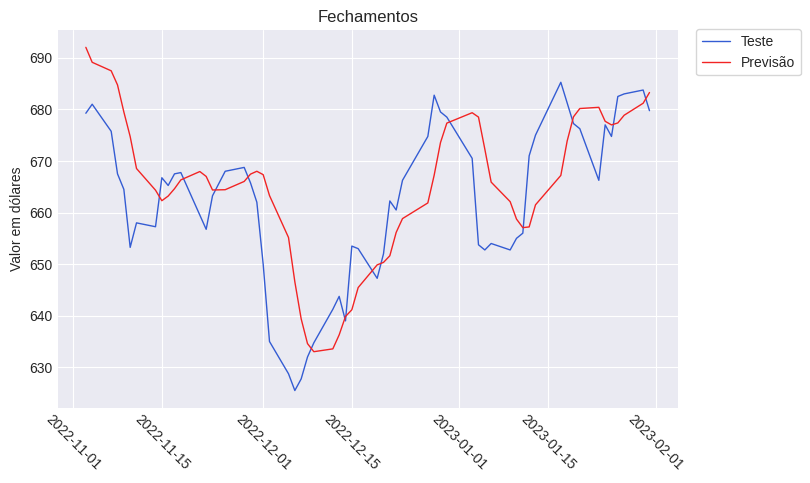

In [ ]:
grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=tf.squeeze(horizontes_teste),
               X_previsao=X_test[-len(janelas_teste):], y_previsao=tf.squeeze(previsoes),
               inicio=-60)

In [ ]:
metricas[8] = metricas_modelo(tf.squeeze(horizontes_teste), tf.squeeze(previsoes))

## Modelo 9: TensorFlow Bidirectional LSTM

In [ ]:
tf.random.set_seed(SEMENTE)

modelo_nome = 'modelo_9_bi_lstm'

modelo = Sequential(name=modelo_nome)

modelo.add(Lambda(lambda x: tf.expand_dims(x, axis=1), name='camada_lambda'))
modelo.add(Bidirectional(layer=LSTM(units=UNIDADES, activation=ATIVACAO_CNN), name='camada_bi_lstm'))
modelo.add(Dense(units=horizonte_tamanho, activation=ATIVACAO_HORIZONTE, name='camada_saida'))

modelo.compile(loss=PERDA,
               optimizer=Adam(),
               metrics=METRICAS)

modelo.fit(x=janelas_treino,
           y=horizontes_treino,
           epochs=ITERACOES,
           batch_size=TAMANHO_LOTE,
           validation_data=(janelas_teste, horizontes_teste),
           callbacks=[criar_marco_modelo(modelo_nome, caminho=CAMINHO_MARCOS)],
           verbose=0)

In [ ]:
modelo.summary()

Model: "modelo_9_bi_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 camada_lambda (Lambda)      (None, 1, 8)              0         
                                                                 
 camada_bi_lstm (Bidirection  (None, 256)              140288    
 al)                                                             
                                                                 
 camada_saida (Dense)        (None, 1)                 257       
                                                                 
Total params: 140,545
Trainable params: 140,545
Non-trainable params: 0
_________________________________________________________________


In [ ]:
modelo.evaluate(janelas_teste, horizontes_teste)

16/16 [==============================] - 0s 3ms/step - loss: 10.6726 - mae: 10.6726 - mse: 252.4380


[10.672577857971191, 10.672577857971191, 252.43801879882812]

In [ ]:
modelo = load_model(os.path.join(CAMINHO_MARCOS, modelo_nome))
modelo.evaluate(janelas_teste, horizontes_teste)

16/16 [==============================] - 0s 3ms/step - loss: 10.6197 - mae: 10.6197 - mse: 258.3464


[10.619671821594238, 10.619671821594238, 258.346435546875]

In [ ]:
previsoes = modelo.predict(janelas_teste)

16/16 [==============================] - 0s 3ms/step


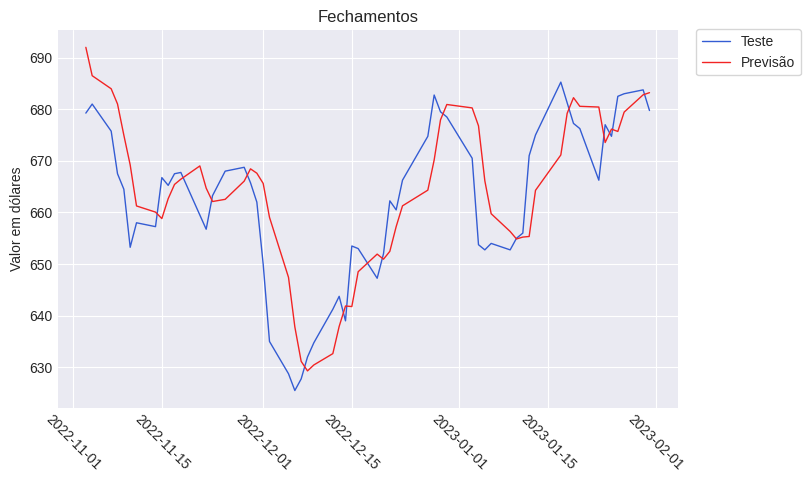

In [ ]:
grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=tf.squeeze(horizontes_teste),
               X_previsao=X_test[-len(janelas_teste):], y_previsao=tf.squeeze(previsoes),
               inicio=-60)

In [ ]:
metricas[9] = metricas_modelo(tf.squeeze(horizontes_teste), tf.squeeze(previsoes))

## Modelo 10: TensorFlow Deeper Dense

In [ ]:
tf.random.set_seed(SEMENTE)

modelo_nome = 'modelo_10_denso_profundo'

modelo = Sequential(name=modelo_nome)

for c in range(4):
    modelo.add(Dense(units=TAMANHO_CNN, activation=ATIVACAO_CNN, name=f'camada_relu_{c + 1}'))

modelo.add(Dense(units=horizonte_tamanho, activation=ATIVACAO_HORIZONTE, name='camada_saida'))

modelo.compile(loss=PERDA,
               optimizer=Adam(),
               metrics=METRICAS)

historico = modelo.fit(x=janelas_treino,
                       y=horizontes_treino,
                       epochs=ITERACOES,
                       batch_size=TAMANHO_LOTE,
                       validation_data=(janelas_teste, horizontes_teste),
                       callbacks=[criar_marco_modelo(modelo_nome, caminho=CAMINHO_MARCOS)],
                       verbose=0)

In [ ]:
modelo.summary()

Model: "modelo_10_denso_profundo"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 camada_relu_1 (Dense)       (None, 128)               1152      
                                                                 
 camada_relu_2 (Dense)       (None, 128)               16512     
                                                                 
 camada_relu_3 (Dense)       (None, 128)               16512     
                                                                 
 camada_relu_4 (Dense)       (None, 128)               16512     
                                                                 
 camada_saida (Dense)        (None, 1)                 129       
                                                                 
Total params: 50,817
Trainable params: 50,817
Non-trainable params: 0
_________________________________________________________________


In [ ]:
modelo.evaluate(janelas_teste, horizontes_teste)

16/16 [==============================] - 0s 11ms/step - loss: 10.0315 - mae: 10.0315 - mse: 228.2692


[10.031466484069824, 10.031466484069824, 228.26922607421875]

In [ ]:
modelo = load_model(os.path.join(CAMINHO_MARCOS, modelo_nome))
modelo.evaluate(janelas_teste, horizontes_teste)

16/16 [==============================] - 0s 3ms/step - loss: 9.4062 - mae: 9.4062 - mse: 204.7943


[9.406229019165039, 9.406229019165039, 204.79432678222656]

In [ ]:
previsoes = modelo.predict(janelas_teste)

16/16 [==============================] - 0s 2ms/step


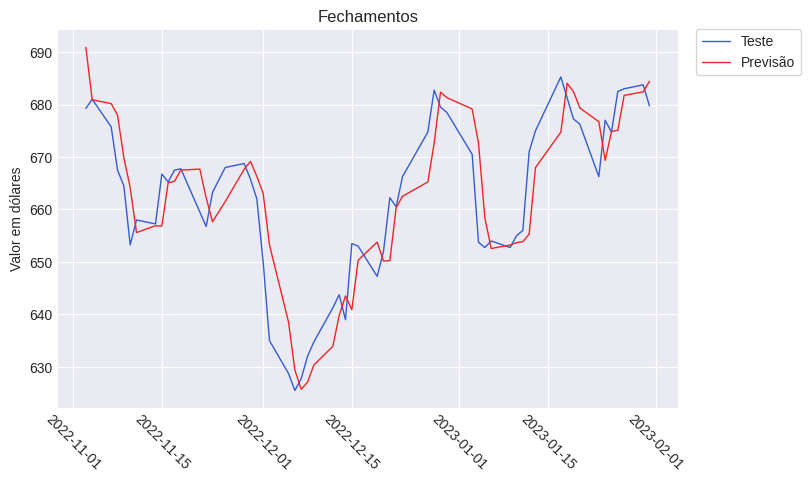

In [ ]:
grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=tf.squeeze(horizontes_teste),
               X_previsao=X_test[-len(janelas_teste):], y_previsao=tf.squeeze(previsoes),
               inicio=-60)

In [ ]:
metricas[10] = metricas_modelo(tf.squeeze(horizontes_teste), tf.squeeze(previsoes))

# Comparação dos modelos

Como as métricas de regressão são medidas de erro, quanto **menor** o valor, melhor o índice.

In [ ]:
df_metricas = pd.DataFrame([m for m in metricas if m is not None])
df_metricas.T

,0,1,2,3,4,5,6,7,8,9,10
Mean Absolute Error,9.159116,9.422268,114.400583,26.522844,10.642442,10.075165,11.340599,12.188627,12.544724,10.619671,9.406229
Root Mean Squared Error,13.792207,13.918371,144.262265,39.015615,15.158750,15.144785,17.132030,18.337595,18.915556,16.073160,14.310637
Mean Absolute Percentage Error,0.014169,0.014548,0.163830,0.037678,0.016444,0.015649,0.017635,0.018925,0.019491,0.016489,0.014602
Mean Absolute Scaled Error,0.998464,1.027151,12.471163,2.891338,1.160166,1.098325,1.236274,1.328720,1.367539,1.157683,1.025402


In [ ]:
df_metricas['Mean Absolute Error'].sort_values()[:3]

0     9.159116
10    9.406229
1     9.422268
Name: Mean Absolute Error, dtype: float64

In [ ]:
# for titulo in metricas[0].keys():
#     grafico_metrica([m[titulo] for m in metricas if m is not None], titulo)